We use this notebook to investigate the pixel shift caused by ee.export()

In [13]:
import os
service_prefix = ''
os.environ['LOCALTILESERVER_CLIENT_PREFIX'] = f"{service_prefix}/proxy/{{port}}"
import sys
import ee
import geemap
import numpy as np
import tqdm
import cv2
import seaborn as sns
from datetime import datetime
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from omegaconf import DictConfig, OmegaConf
import hydra
import pandas as pd
import cv2
from util.ee_utils import (acquire_reference_date, generate_cycles,
                           get_landsat_lst, get_landsat_capture_time, load_ee_image,
                           is_landsat_pixel_clear, query_geotiff)
from eval.surfrad import get_surfrad_surf_temp_at
from rich.progress import Progress
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Original half a pixel shift

In [2]:
vis = {
  'min': 280,
  'max': 340,
  'palette' : sns.color_palette('inferno', 20).as_hex(),
}
config = OmegaConf.load('../config/surfrad.yaml')
station_id = 'BND'
date_ = '20170611'
lon = config['stations'][station_id]['Longitude']
lat = config['stations'][station_id]['Latitude']
scene_id = config['stations'][station_id]['scene_id']
Map = geemap.Map()
Map.add_basemap('HYBRID')

img_path = f'/home/yuhaoliu/Code/UrbanSurfTemp/data/{station_id}/lst/LC08_ST_B10_{date_}.tif'
# output_path = '/home/yuhaoliu/Code/UrbanSurfTemp/data/Austin/output_referenced_f75/lst/20170303.tif'
image = ee.Image(f'LANDSAT/LC08/C02/T1_L2/LC08_{scene_id}_{date_}')
Map.add_raster(img_path, palette=vis['palette'], vmax=vis['max'], vmin=vis['min'], layer_name='downloaded_lst')
Map.addLayer(image.select('ST_B10').multiply(0.00341802).add(149), vis, 'landsat_lst')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Debugging the issue by exporting to Google Drive 

```python
geemap.ee_export_image_to_drive(img, description="entire_image_all_bands", folder="export", region=None, scale=30)
geemap.ee_export_image_to_drive(img.select('ST_B10'), description="entire_image_bt10", folder="export", region=None, scale=30)
geemap.ee_export_image_to_drive(img.select('ST_B10').multiply(0.00341802).add(149), description="entire_image_scaled", folder="export", region=None, scale=30)
geemap.ee_export_image_
```

In [2]:
vis = {
  'min': 280,
  'max': 340,
  'palette' : sns.color_palette('inferno', 20).as_hex(),
}
config = OmegaConf.load('../config/surfrad.yaml')
station_id = 'BND'
date_ = '20170611'
lon = config['stations'][station_id]['Longitude']
lat = config['stations'][station_id]['Latitude']
scene_id = config['stations'][station_id]['scene_id']
Map = geemap.Map()
Map.add_basemap('HYBRID')

image = ee.Image(f'LANDSAT/LC08/C02/T1_L2/LC08_{scene_id}_{date_}')
downloaded_path = f'/home/yuhaoliu/Code/UrbanSurfTemp/data/{station_id}/lst/LC08_ST_B10_{date_}.tif'
# entire_bt10 = '/home/yuhaoliu/Data/ISLAND/gdrive/entire_image_bt10.tif'
entire_scaled = '/home/yuhaoliu/Data/ISLAND/gdrive/entire_image_scaled.tif'
cropped_scaled = '/home/yuhaoliu/Data/ISLAND/gdrive/cropped_scaled.tif'
Map.add_raster(downloaded_path, palette=vis['palette'], vmax=vis['max'], vmin=vis['min'], layer_name='downloaded_lst')
Map.add_raster(cropped_scaled, palette=vis['palette'], vmax=vis['max'], vmin=vis['min'], layer_name='cropped_scaled')
Map.add_raster(entire_scaled, palette=vis['palette'], vmax=vis['max'], vmin=vis['min'], layer_name='entire_scaled')
Map.addLayer(image.select('ST_B10').multiply(0.00341802).add(149), vis, 'landsat_lst')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [6]:
lon, lat = -88.261, 40.145

landsat_lst = get_landsat_lst(lon, lat, image=image)
capture_time = get_landsat_capture_time(image=image)
print(f'LANDSAT LST = {landsat_lst} K')

direct_download_lst = query_geotiff(lon, lat, downloaded_path)
print(f'Direct download GeoTIFF LST = {direct_download_lst}')

gdrive_lst = query_geotiff(lon, lat, cropped_scaled)
print(f'Gdrive GeoTIFF LST = {gdrive_lst}')

LANDSAT LST = 334.53696163999996 K
Direct download GeoTIFF LST = 331.79912762000004
Gdrive GeoTIFF LST = 334.53696163999996


When ee.Image are exported to Google Drive, even when there is cropping applied, there is no pixel shift.

## Loading modified images

In [2]:
vis = {
  'min': 280,
  'max': 340,
  'palette' : sns.color_palette('inferno', 20).as_hex(),
}
config = OmegaConf.load('../config/surfrad.yaml')
station_id = 'BND'
date_ = '20170611'
lon = config['stations'][station_id]['Longitude']
lat = config['stations'][station_id]['Latitude']
scene_id = config['stations'][station_id]['scene_id']
Map = geemap.Map()
Map.add_basemap('HYBRID')

img_path = f'/home/yuhaoliu/Code/UrbanSurfTemp/data/{station_id}/lst/LC08_ST_B10_{date_}.tif'
aligned_path = '/home/yuhaoliu/Code/UrbanSurfTemp/tmp/align.tif'
image = ee.Image(f'LANDSAT/LC08/C02/T1_L2/LC08_{scene_id}_{date_}')
Map.add_raster(img_path, palette=vis['palette'], vmax=vis['max'], vmin=vis['min'], layer_name='downloaded_lst')
Map.add_raster(aligned_path, palette=vis['palette'], vmax=vis['max'], vmin=vis['min'], layer_name='aligned_lst')
Map.addLayer(image.select('ST_B10').multiply(0.00341802).add(149), vis, 'landsat_lst')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [5]:
lon, lat = -88.261, 40.145

landsat_lst = get_landsat_lst(lon, lat, image=image)
capture_time = get_landsat_capture_time(image=image)
print(f'LANDSAT LST = {landsat_lst} K')

direct_download_lst = query_geotiff(lon, lat, img_path)
print(f'Direct download GeoTIFF LST = {direct_download_lst}')

aligned_lst = query_geotiff(lon, lat, aligned_path)
print(f'Aligned GeoTIFF LST = {aligned_lst}')

LANDSAT LST = 334.53696163999996 K
Direct download GeoTIFF LST = 331.79912762000004
Aligned GeoTIFF LST = 334.53696163999996


Success!

In [2]:
vis = {
  'min': 270,
  'max': 320,
  'palette' : sns.color_palette('inferno', 20).as_hex(),
}
config = OmegaConf.load('../config/surfrad.yaml')
station_id = 'PSU'
date_ = '20170322'
lon = config['stations'][station_id]['Longitude']
lat = config['stations'][station_id]['Latitude']
scene_id = config['stations'][station_id]['scene_id']
Map = geemap.Map()
Map.add_basemap('HYBRID')

img_path = f'/home/yuhaoliu/Code/UrbanSurfTemp/data/{station_id}/lst/LC08_ST_B10_{date_}.tif'
aligned_path = '/home/yuhaoliu/Code/UrbanSurfTemp/tmp/align_2.tif'
image = ee.Image(f'LANDSAT/LC08/C02/T1_L2/LC08_{scene_id}_{date_}')
Map.add_raster(img_path, palette=vis['palette'], vmax=vis['max'], vmin=vis['min'], layer_name='downloaded_lst')
Map.add_raster(aligned_path, palette=vis['palette'], vmax=vis['max'], vmin=vis['min'], layer_name='aligned_lst')
Map.addLayer(image.select('ST_B10').multiply(0.00341802).add(149), vis, 'landsat_lst')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Repeated success on another SURFARD station. When specifying crs.transform, there is no longer projection error from geemap.export()!

## Is NLCD projected correctly?

#### hide

In [3]:
vis = {
  'min': 280,
  'max': 340,
  'palette' : sns.color_palette('inferno', 20).as_hex(),
}
config = OmegaConf.load('../config/surfrad.yaml')
station_id = 'BND'
date_ = '20170611'
lon = config['stations'][station_id]['Longitude']
lat = config['stations'][station_id]['Latitude']
scene_id = config['stations'][station_id]['scene_id']
Map = geemap.Map()
Map.add_basemap('HYBRID')

img_path = f'/home/yuhaoliu/Code/UrbanSurfTemp/data/{station_id}/lst/LC08_ST_B10_{date_}.tif'
aligned_path = '/home/yuhaoliu/Code/UrbanSurfTemp/tmp/align.tif'
# nlcd_path = f'/home/yuhaoliu/Code/UrbanSurfTemp/data/{station_id}/nlcd_20170203.tif'
nlcd_no_transform = '/home/yuhaoliu/Code/UrbanSurfTemp/tmp/nlcd_no_crs_transform.tif'
nlcd_transform = '/home/yuhaoliu/Code/UrbanSurfTemp/tmp/nlcd_with_crs_transform.tif'
image = ee.Image(f'LANDSAT/LC08/C02/T1_L2/LC08_{scene_id}_{date_}')
Map.add_raster(img_path, palette=vis['palette'], vmax=vis['max'], vmin=vis['min'], layer_name='downloaded_lst')
Map.add_raster(aligned_path, palette=vis['palette'], vmax=vis['max'], vmin=vis['min'], layer_name='aligned_lst')
Map.addLayer(image.select('ST_B10').multiply(0.00341802).add(149), vis, 'landsat_lst')
Map.add_raster(nlcd_no_transform, layer_name='nlcd')
Map.add_raster(nlcd_transform, layer_name='nlcd_transform')
Map

ValueError: The source path does not exist.

#### result

In [2]:

Map = geemap.Map()
Map.add_basemap('NLCD 2019 CONUS Land Cover')
# nlcd = '/home/yuhaoliu/Code/UrbanSurfTemp/tmp/nlcd_crs.tif'
nlcd_color = '/home/yuhaoliu/Code/UrbanSurfTemp/tmp/nlcd_crs_rgb.tif'
nlcd_color2 = '/home/yuhaoliu/Code/UrbanSurfTemp/tmp/nlcd_no_transform_rgb.tif'
nlcd_color3 = '/home/yuhaoliu/Code/UrbanSurfTemp/tmp/nlcd_no_crs_rgb.tif'
nlcd_color4 = '/home/yuhaoliu/Code/UrbanSurfTemp/tmp/nlcd_no_crs_no_scale_rgb.tif'
# Map.add_raster(nlcd, layer_name='nlcd')
Map.add_raster(nlcd_color, layer_name='nlcd_color')
Map.add_raster(nlcd_color2, layer_name='no_transform')
Map.add_raster(nlcd_color3, layer_name='no_crs')
Map.add_raster(nlcd_color4, layer_name='no_crs_no_scale')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

There is a subtle pixel shift for NLCD. The shift appears to be random affine transform locally. Within one image, such affine transform is not unirform, unlike the shift observed for LANDSAT images. </br>
Several attempts have been made to mitigate this shift, including: 
* toggleing `scale=30` (no effect)
* toggling `crs=projection['crs']` (when off, all lines are tilted)
* toggling `crs_transform=projection['transform']` (produces different shifts, hard to say which one is better)
Unfortuneately none of these efforts work. </br>
However, since we have enabled `crs_transform=projection['transform']` when exporting LANDSAT images, we have to include this for exporting NLCD as well, otherwise the exported dimensions will differ between LANDSAT and NLCD. </br>
**The shift for NLCD currently remains unresovled.** (as of Mar 4 2024)

## Re-generate timeseris plot

In [9]:
station_id = 'BND'
start_date = '20170101'
end_date = '20220101'

config = OmegaConf.load('../config/surfrad.yaml')
lon = config['stations'][station_id]['Longitude']
lat = config['stations'][station_id]['Latitude']
scene_id = config['stations'][station_id]['scene_id']

ref_date = acquire_reference_date(start_date, scene_id)
cycles = generate_cycles(ref_date, end_date)
data = []
with Progress() as progress:
    task_id = progress.add_task("[cyan]Processing...", total=len(cycles))
    for date_ in cycles:
        try:
            image = load_ee_image(f'LANDSAT/LC08/C02/T1_L2/LC08_{scene_id}_{date_}')
            landsat_lst = get_landsat_lst(lon, lat, image=image)
            capture_time = get_landsat_capture_time(image=image)
            img_path = f'/home/yuhaoliu/Code/UrbanSurfTemp/data/{station_id}/lst/LC08_ST_B10_{date_}.tif'
            download_lst = query_geotiff(lon, lat, img_path)
            surfrad_lst = get_surfrad_surf_temp_at(station_id, capture_time)
            island_path = f'/home/yuhaoliu/Code/UrbanSurfTemp/data/{station_id}/output_referenced/lst/lst_{date_}.tif'
            island_lst = query_geotiff(lon, lat, island_path)
            condition_clear = is_landsat_pixel_clear(lon, lat, image=image)
            data.append({
                'date': date_,
                'landsat_lst': landsat_lst,
                'surfrad_lst': surfrad_lst,
                'download_lst': download_lst,
                'island_lst': island_lst,
                'condition_clear': condition_clear,
            })
        except (ee.EEException, ValueError) as e:
            continue
        progress.update(task_id, advance=1)
df = pd.DataFrame(data)

Output()

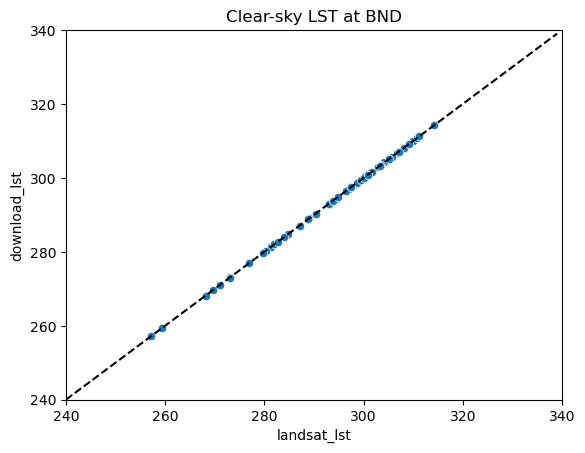

RMSE: 0.00, Bias: 0.00, MAE: 0.00
Num = 60


In [14]:
a, b =  'download_lst', 'landsat_lst'
# Filter the DataFrame
df_filtered = df[df['condition_clear']]

# Create a scatter plot
plt.figure()
sns.scatterplot(y=a, x=b, data=df_filtered)
# Add a dashed black line y = x
x = range(240, 340)
plt.plot(x, x, color='black', linestyle='--')
# Set x and y limits
plt.xlim(240, 340)
plt.ylim(240, 340)
plt.title(f'Clear-sky LST at {station_id}' )
plt.show()

# Compute the errors
errors =  df_filtered[a] - df_filtered[b]
# Compute the RMSE
rmse = np.sqrt((errors**2).mean())
# Compute the bias
bias = errors.mean()
# Compute the MAE
mae = mean_absolute_error(df_filtered[a], df_filtered[b])
print(f"RMSE: {rmse:.2f}, Bias: {bias:.2f}, MAE: {mae:.2f}")
print('Num =', len(df_filtered))

There is no error between querying Google Earth Engine LANDSAT images and querying downloaded images!

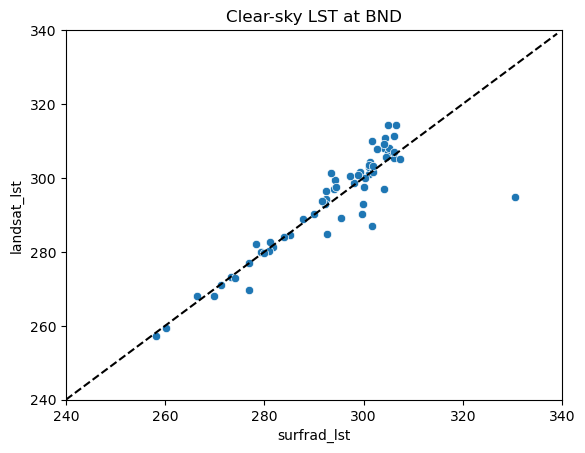

RMSE: 6.32, Bias: 0.05, MAE: 3.66
Num = 60


In [16]:
a, b =  'landsat_lst', 'surfrad_lst'
# Filter the DataFrame
df_filtered = df[df['condition_clear']]

# Create a scatter plot
plt.figure()
sns.scatterplot(y=a, x=b, data=df_filtered)
# Add a dashed black line y = x
x = range(240, 340)
plt.plot(x, x, color='black', linestyle='--')
# Set x and y limits
plt.xlim(240, 340)
plt.ylim(240, 340)
plt.title(f'Clear-sky LST at {station_id}' )
plt.show()

# Compute the errors
errors =  df_filtered[a] - df_filtered[b]
# Compute the RMSE
rmse = np.sqrt((errors**2).mean())
# Compute the bias
bias = errors.mean()
# Compute the MAE
mae = mean_absolute_error(df_filtered[a], df_filtered[b])
print(f"RMSE: {rmse:.2f}, Bias: {bias:.2f}, MAE: {mae:.2f}")
print('Num =', len(df_filtered))

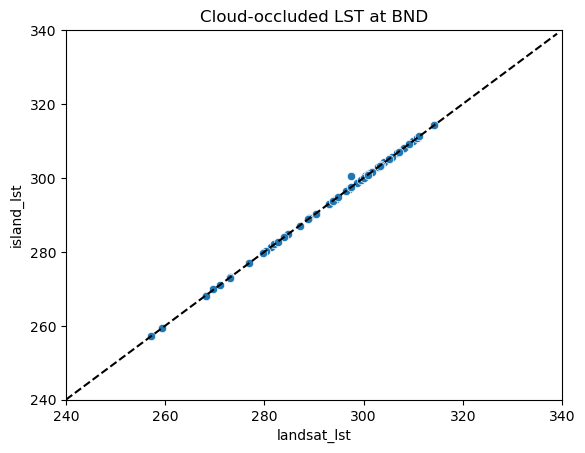

RMSE: 0.40, Bias: 0.05, MAE: 0.06
Num = 60


In [25]:
a, b =  'island_lst', 'landsat_lst'
# Filter the DataFrame
df_filtered = df[df['condition_clear']]
# Create a scatter plot
plt.figure()
sns.scatterplot(y=a, x=b, data=df_filtered)
# Add a dashed black line y = x
x = range(240, 340)
plt.plot(x, x, color='black', linestyle='--')
# Set x and y limits
plt.xlim(240, 340)
plt.ylim(240, 340)
plt.title(f'Cloud-occluded LST at {station_id}' )
plt.show()

# Compute the errors
errors =  df_filtered[a] - df_filtered[b]
# Compute the RMSE
rmse = np.sqrt((errors**2).mean())
# Compute the bias
bias = errors.mean()
# Compute the MAE
mae = mean_absolute_error(df_filtered[a], df_filtered[b])
print(f"RMSE: {rmse:.2f}, Bias: {bias:.2f}, MAE: {mae:.2f}")
print('Num =', len(df_filtered))

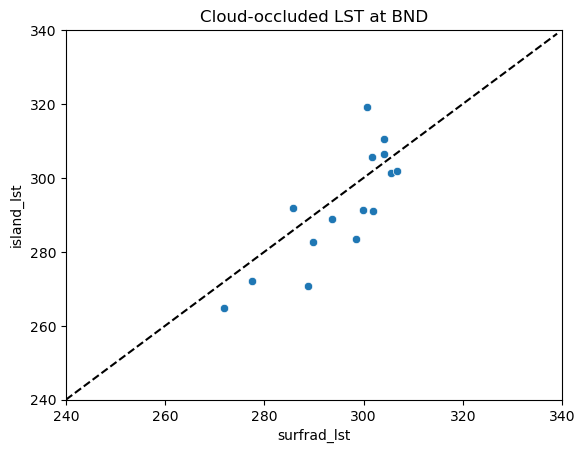

RMSE: 9.56, Bias: -3.26, MAE: 8.20
Num = 15


In [24]:
a, b =  'island_lst', 'surfrad_lst'
# Filter the DataFrame
df_filtered = df[df['condition_clear'] == False]
df_filtered = df_filtered[df_filtered['island_lst'] > 0]
# Create a scatter plot
plt.figure()
sns.scatterplot(y=a, x=b, data=df_filtered)
# Add a dashed black line y = x
x = range(240, 340)
plt.plot(x, x, color='black', linestyle='--')
# Set x and y limits
plt.xlim(240, 340)
plt.ylim(240, 340)
plt.title(f'Cloud-occluded LST at {station_id}' )
plt.show()

# Compute the errors
errors =  df_filtered[a] - df_filtered[b]
# Compute the RMSE
rmse = np.sqrt((errors**2).mean())
# Compute the bias
bias = errors.mean()
# Compute the MAE
mae = mean_absolute_error(df_filtered[a], df_filtered[b])
print(f"RMSE: {rmse:.2f}, Bias: {bias:.2f}, MAE: {mae:.2f}")
print('Num =', len(df_filtered))

## Are there shifts between downloaded LANDSAT images from different dates?

In [28]:
vis = {
  'min': 280,
  'max': 340,
  'palette' : sns.color_palette('inferno', 20).as_hex(),
}

img1 = '/home/yuhaoliu/Code/UrbanSurfTemp/data/Houston/lst/LC08_ST_B10_20170116.tif'
img2 = '/home/yuhaoliu/Code/UrbanSurfTemp/data/Houston/lst/LC08_ST_B10_20200125.tif'
Map = geemap.Map()
Map.add_raster(img1, palette=vis['palette'], vmax=vis['max'], vmin=vis['min'], layer_name='1')
Map.add_raster(img2, palette=vis['palette'], vmax=vis['max'], vmin=vis['min'], layer_name='2')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

**No, they appear to align perfectly**